# Solving Dynamical Systems using Reservoir Computing

In [1]:
from QRC.solvers import *
from QRC.systems import *
from QRC.post_process import *
from QRC.crc import *
from QRC.qrc import *
from QRC.validation import *
# from QRC.lyapunov import *
#from QRC.lyapunov_gm import *
#numpy
import numpy as np
#plotting libraries
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib as mpl
#scipy libraries
import sklearn
from skopt.space import Real
from skopt.learning import GaussianProcessRegressor as GPR
from skopt.learning.gaussian_process.kernels import Matern, WhiteKernel, Product, ConstantKernel
#time libraries
import h5py
import time
from datetime import date
from timeit import default_timer as timer
today = date.today()

mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')
mpl.rcParams['text.usetex']

#TODO
# Add config file so that to run on HPC


True

# Select Systems and Parameters

In [2]:
#for Lorenz 63:
if __name__ == "__main__":
    dt = 0.01
    tot_steps = 100000
    upsample = 1
    q0 =  np.array([7.432487609628195, 10.02071718705213, 29.62297428638419])
    u0 = q0
    #q0 =  np.array([0, 1, 1])
    N_transient = 2000


save_fold = 'VPT_L63'
system = Systems(dt,tot_steps,q0,upsample,N_transient)

dim,N_lyap,N_t = system.set_param_lorenz63() # FOR MFE, N_t should be input so in set_param_MFE -- make it as input
q = system.gen_data_lorenz63()


# for MFE:
# if __name__ == "__main__":
#     dt = 0.25
#     tot_steps = 20000
#     upsample = 1
#     q0   = np.array([1, 0.07066, -0.07066, 0, 0, 0, 0, 0, 0]) 
#     u0   = q0
#     N_t = 2000
#     N_transient = 1000

# save_fold= 'MFE'
# system = Systems(dt,tot_steps,q0,upsample,N_transient)
# sys = 'MFE'
# dim,N_lyap = system.set_param_MFE(N_t) 

# run = False
# save= False
# load = True

# if run:
#     q = system.gen_data_MFE()

# if save:
#     fln = './data/MFE'+'MFE'+'_dt='+str(dt)+'_Nt='+str(N_t)+'_dim='+str(dim)+'_date='+str() # Enter Date
#     hf = h5py.File(fln,'w')
#     hf.create_dataset('q',data=q)
#     hf.close()

# if load:
#     hf      = h5py.File('./data/MFE/'+'MFE'+'_dt='+str(dt)+'_Nt='+str(N_t)+'_dim='+str(dim)+'_date='+str('2023-07-31'))
#     q       = np.array(hf.get('q'))
#     hf.close()


# Pre-process input data 

In [3]:
data_inputs = True
noise       = False # to add noise in flattened time series 
scaling     = True # to scale flattened time series 

if data_inputs:
    N_ts        = 1 # 1 for L63 and L96, 20 for MFE
    N_test_stat = 500 # Time series for testing after N_ts

    N_washout  = 2*N_lyap #10 before for L96 10 D , 2 before for L63 / MFE  
    N_val      = 2*N_lyap # 3 for L63 , # 5 for L96 , 2*N_lyap for MFE
    N_train    = 20*N_lyap #200 before for L96 10D , 20 before for L63 / MFE  
    N_test     = 200*N_lyap
 


# All above in this block are Inputs
q_unscaled = q
UU = q # backup of complete time series
print('Laminarized precentage', np.round(100-((q.shape[0])*100/N_t),2),'(relevant for MFE)')

q = q[:N_ts+N_test_stat,:,:] # trimmed time series

print('Retaining ',N_ts, 'series for training and validation')
print('Additional ',N_test_stat, 'series for testing and statistical predictions')

# Rescaling Input Time Series after flattening it (only retained series)
q0 = q.shape[0] # Total time series, Train+Val+Test
q1 = q.shape[1] # Length of each time series
q_U = q.reshape(q0*q1, dim)

if scaling:
    q = sklearn.preprocessing.minmax_scale(q_U, feature_range=(0, 1), axis=0, copy=True) # rescaling flattened array
    q  = q.reshape(q0,q1,dim) # making 3 dimensional again

# from here q has scaled data
q_tv = q[:N_ts,:,:]  # From q retaining training set (N_ts)
q_test = q[N_ts:N_ts+N_test_stat,:,:]  #From q removing retaining test set(N_test_stat)

# Training, Validation Parameters
UU = q_tv # Training, validation set
N0 = UU.shape[0] # Retained Time series for training
N1 = UU.shape[1] # Length of each time series
print('UU Size =',UU.shape) # 3 dim
U = UU.reshape(N0*N1, dim) # Generating flattened time series for addition of noise and normalization
print('U Size =',U.shape) # 2 dim 

if noise: # adding noise in training set
    target_snr_db=40
    seed=0
    UU = add_noise(U,target_snr_db,seed,dim,N0,N1)

#compute norm
U_data = U[:N_washout+N_train+N_val]
m = U_data.min(axis=0)
M = U_data.max(axis=0)
norm = M-m
u_mean = U_data.mean(axis=0)

# washout
U_washout = UU[:,:N_washout]
# training + validation
U_tv  = UU[:,N_washout:N_washout+N_train+N_val-1]
Y_tv  = UU[:,N_washout+1:N_washout+N_train+N_val]
# Testing
U_test  = UU[:,N_washout+N_train+N_val:N_washout+N_train+N_val+N_test-1]
Y_test  = UU[:,N_washout+N_train+N_val+1:N_washout+N_train+N_val+N_test]

print('N_lyap:', N_lyap)
print('N_train =',int(N_train/N_lyap),'N_lyap',' x ',str(N_ts),'series')
print('N =',int((N_washout+N_val+N_train)/N_lyap),'N_lyap',', Total steps of training=',int(N_washout+N_val+N_train),', Out of = ',N0*N1)
print('The shape of q_tv is '+str(q_tv.shape)+ ' to train on ' +str(N_ts)+  ' time series')
print('The shape of q_test is '+str(q_test.shape)+ ' to test ' +str(N_test_stat)+  ' time series, and for stats predictions (relevant for MFE)')
print('The shape of q is '+str(q.shape)+ ' combining above')
print('The shape of U_test is '+str(U_test.shape)+ ' combining above')


Laminarized precentage 0.0 (relevant for MFE)
Retaining  1 series for training and validation
Additional  500 series for testing and statistical predictions
UU Size = (1, 98000, 3)
U Size = (98000, 3)
N_lyap: 111
N_train = 20 N_lyap  x  1 series
N = 24 N_lyap , Total steps of training= 2664 , Out of =  98000
The shape of q_tv is (1, 98000, 3) to train on 1 time series
The shape of q_test is (0, 98000, 3) to test 500 time series, and for stats predictions (relevant for MFE)
The shape of q is (1, 98000, 3) combining above
The shape of U_test is (1, 22199, 3) combining above


# Visualize input data

In [4]:
# l1 = 8000
# l2 = 5000
# l3 = 5000

# plot_lorenz63_attractor(U,l1)
# plot_lorenz63_time(U,N_lyap,l2,l3)
# plt.show()

# Calculate Lyapunov Exponents from data

Dynamical system: lorenz63
Target Lyapunov exponents:  [ 8.79376470e-01  4.48530221e-03 -1.45504276e+01]
Dynamical system: lorenz63
Target Lyapunov exponents:  [ 9.00274255e-01  1.42083691e-03 -1.45682595e+01]
Dynamical system: lorenz63
Target Lyapunov exponents:  [ 9.24070967e-01 -5.80717442e-03 -1.45848271e+01]
Dynamical system: lorenz63
Target Lyapunov exponents:  [ 9.03105034e-01 -6.55211634e-03 -1.45631183e+01]
Dynamical system: lorenz63
Target Lyapunov exponents:  [ 8.86022934e-01  6.67927652e-03 -1.45592674e+01]


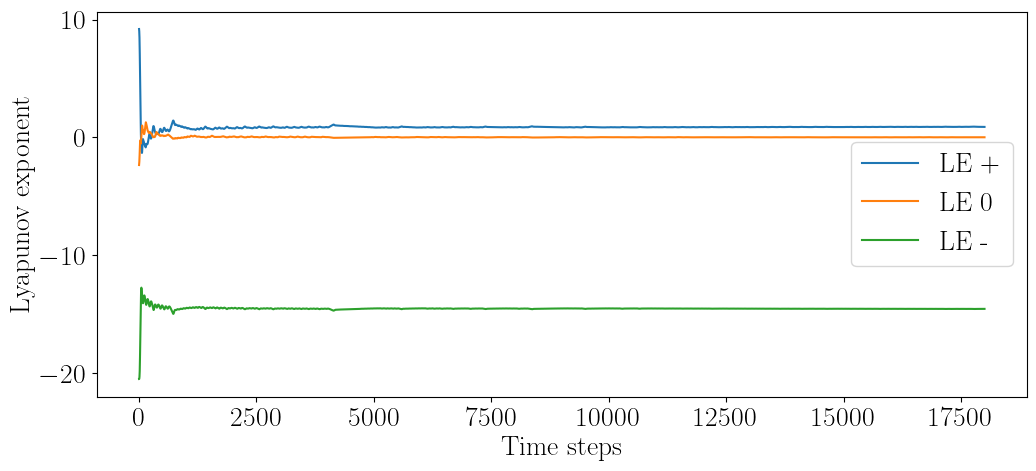

In [5]:

# # The total timesteps
# Ntotal = (N_washout+N_train+N_val+N_test)*upsample
# #Timesteps to be discraded as a transient for the initial LEs and CLVs calculation
# Ntherm = (N_washout+N_train+N_val)*upsample + int(N_test*upsample/10)

Ntotal = 20000
Ntherm = int(Ntotal /10)

if save_fold == 'VPT_L63':
    sys = 'lorenz63'
    # params = [8/3, 28, 10]

if save_fold == 'MFE':
    sys = 'MFE'
    params = []
    
ensemble= 5


for realization in range(ensemble):       

    if save_fold == 'MFE': ## MFE TODO
        k_xt = 1
        l_xt = -1
        kk = 0
        
        #while k_xt >= 0.51:
            # du0 = 0.01*(np.random.rand(dim) - 0.5) 
        while l_xt <= 0:    
            du14 = 0.01*(np.random.rand(4))
            du0  = np.concatenate([du14,np.zeros(5)])
            
            v0 = u0.copy() + du0
            LEs , xt    = system.solve_system_LEs(sys,Ntotal,Ntherm,v0,dim)
            k_xt = np.max(0.5*np.linalg.norm(xt,axis=1)**2)
             
            print('Ensemble ',realization,'try #',kk, 'Kinetic Energy Max',k_xt)
            print('Lyapunov vector',LEs[-1])
            l_xt = np.max(LEs[-1])
            print('Maximum lyapunov',l_xt)
            kk += 1
            

    else:    
        du0 = 0.01*(np.random.rand(dim) - 0.5)    
        v0 = u0.copy() + du0
        LEs , xt    = system.solve_system_LEs(sys,Ntotal,Ntherm,v0,dim)
    
    LEs_targ = LEs[-1]
    
    print('Target Lyapunov exponents: ',LEs_targ)
    
    
plt.rcParams["figure.figsize"] = (12,5)
plt.rcParams["font.size"] = 20

if save_fold == 'VPT_L63':
    plt.plot(LEs[:,0], label='LE +')
    plt.plot(LEs[:,1], label='LE 0')
    plt.plot(LEs[:,2], label='LE -')
    
if save_fold == 'MFE':
    plt.plot(LEs[:,0],label='Leading LE')
    plt.legend()
    plt.xlabel("Time steps")
    plt.ylabel("Lyapunov exponent")
    plt.show()
    plt.plot(LEs)


plt.xlabel("Time steps")
plt.ylabel("Lyapunov exponent")
plt.legend()
plt.show()

# Classical Reservoir Initialization

In [6]:
# Required Input Parameters
bias_in   = np.array([np.mean(np.abs((U_data-u_mean)/norm))]) #input bias (average absolute value of the inputs)
bias_out  = np.array([1.]) #output bias 
N_units   = 256 #neurons
density = 0.11 # L63
#density = 0.01 # L96
#connectivity = 30

# Predefining Hyperparameter to initiate a class
tikh = np.array([1e-9])  # Tikhonov factor 
sigma_in = 1 # input scaling
rho = 1
epsilon = 1

# Random Weight Matrices Seed
seed = 2

sparseness = 1 - density
connectivity = (1 -  sparseness)*(N_units-1)

# sparseness = 1-((connectivity)/(N_units-1))
# density    = 1-sparseness
print('Density(D) = ',np.round(density,2))
print('Connectivity = ', np.round(connectivity,2))

esn = EchoStateNetwork(tikh,sigma_in,rho,epsilon,bias_in,bias_out,N_units,dim,density)
esn.norm_u = norm

Density(D) =  0.11
Connectivity =  28.05


# Validation (hyperparameter tuning)

In [7]:
n_in        = 10               #Number of Initial random points
n_tot       = 50               #Total number of function evaluations

#range for hyperparameters 
spec_in     = np.log10(0.01)   
spec_end    = np.log10(1.0)   
epsilon_in  = 0.01
epsilon_end = 1
scaling_in  = 0.01
scaling_end = 1
#Number of Networks in the ensemble
ensemble = 5      
    
search_space = [Real(spec_in, spec_end, name='spectral_radius'),
            Real(epsilon_in, epsilon_end, name='epsilon'),
            Real(scaling_in,scaling_end, name = 'input_scaling')]

kernell = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-1, 3e0)) *\
            Matern(length_scale=[0.2,0.1,0.3], nu=2.5, length_scale_bounds=(5e-2, 1e1)) 


k= 0
# Which validaton strategy (implemented in Val_Functions.ipynb)
val      = RVC_Noise_upt
N_fo     = max(50,2)            # number of validation intervals
N_in     = N_washout                  # timesteps before the first validation interval (can't be 0 due to implementation)
N_fw     = (N_train-N_val)//(N_fo-1) # how many steps forward the validation interval is shifted (in this way they are evenly spaced)

#Quantities to be saved
par      = np.zeros((ensemble, 5))      # GP parameters
x_iters  = np.zeros((ensemble,n_tot,len(search_space))) # coordinates in hp space where f has been evaluated
f_iters  = np.zeros((ensemble,n_tot))   # values of f at those coordinates
minimum  = np.zeros((ensemble, len(search_space)+2))      # minima found per each member of the ensemble

# to store optimal hyperparameters and matrices
tikh_opt = np.zeros(n_tot)
Woutt    = np.zeros(((ensemble, N_units+1,dim)))
Winn     = [] #save as list to keep single elements sparse
Ws       = [] 
biass    = []
rho_ens  = []
epsilon_ens = []
sigma_in_ens = []
Xa_cc        = []
LHS_cc       = []
RHS_cc       = []

# save the final gp reconstruction for each network
gps        = [None]*ensemble

# to print performance of every set of hyperparameters
print_flag = False



In [8]:
## TODO fix k, global issues for classical hyperparam opt print statements
run_hyperparam = True

if run_hyperparam:
    for i in range(ensemble):
        
        print('Realization    :',i+1)
        
        k   = 0
        
        # Win and W generation
        seed= i+1
        rnd = np.random.RandomState(seed)

        Win =  esn.gen_input_matrix(seed)
        W =  esn.gen_reservoir_matrix(seed)
        
        # Bayesian Optimization
        tt       = time.time()
        res      = validate(val,kernell,search_space,n_in,n_tot,esn,tikh,N_fo,N_fw,N_in,N_val,N_washout,U,U_washout,U_tv,Y_tv,Win,W,k,tikh_opt)
        print('Total time for the network:', time.time() - tt)
        
        #Saving Quantities for post_processing
        gps[i]     = res.models[-1]    
        gp         = gps[i]
        x_iters[i] = np.array(res.x_iters)
        f_iters[i] = np.array(res.func_vals)
        minimum[i] = np.append(res.x,[tikh_opt[np.argmin(f_iters[i])],res.fun])
        params     = gp.kernel_.get_params()
        key        = sorted(params)
        par[i]     = np.array([params[key[2]],params[key[5]][0], 1, gp.noise_,params[key[5]][1]])

        esn.rho      = 10**minimum[i,0]
        esn.epsilon  = minimum[i,1]
        esn.sigma_in = minimum[i,2]

        Woutt[i] = esn.train(U_washout, U_tv, Y_tv,Win,W)[1]

        Winn    += [Win] 
        Ws      += [W]   

        #Plotting Optimization Convergence for each network
        print('Best Results: x', 10**minimum[i,0], minimum[i,1],minimum[i,2] ,minimum[i,3],', Min Obj Function =', minimum[i,4])
        print('Hyperparamters:',esn.rho,esn.epsilon,esn.sigma_in)

        plt.rcParams["figure.figsize"] = (15,2)

Realization    : 1
Total time for the network: 39.46919775009155
Best Results: x 1.0 0.7038883306755422 1.0 0.0 , Min Obj Function = -9.278960904673465
Hyperparamters: 1.0 0.7038883306755422 1.0
Realization    : 2
Total time for the network: 39.422762393951416
Best Results: x 1.0 0.5265211622664385 1.0 0.0 , Min Obj Function = -9.268997147933995
Hyperparamters: 1.0 0.5265211622664385 1.0
Realization    : 3
Total time for the network: 39.79225277900696
Best Results: x 1.0 0.7485520767773461 1.0 0.0 , Min Obj Function = -9.29401706560765
Hyperparamters: 1.0 0.7485520767773461 1.0
Realization    : 4


/home/oa1422/Stability_GS/venv_GS/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Total time for the network: 40.12096452713013
Best Results: x 1.0 0.8661289651095819 1.0 0.0 , Min Obj Function = -9.015228361980528
Hyperparamters: 1.0 0.8661289651095819 1.0
Realization    : 5


/home/oa1422/Stability_GS/venv_GS/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/oa1422/Stability_GS/venv_GS/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Total time for the network: 38.918802976608276
Best Results: x 1.0 0.7583625262036464 0.9313781852924004 0.0 , Min Obj Function = -9.28974535482611
Hyperparamters: 1.0 0.7583625262036464 0.9313781852924004


# Loading Hyperparameters


In [9]:
#hf       = h5py.File('./data/VPT_L96/minimum='+str(dt)+'-Nres'+str(N_units)+'-Ensemble'+str(ensemble)+'-dim'+str(dim)) # L96 without noise , its the file for paper
# hf       = h5py.File('./data/VPT_L96/minimum='+str(dt)+'-Nres'+str(N_units)+'-Ensemble'+str(ensemble)+'-dim'+str(dim)+'-noise') # L96 with noise , paper results
#hf       = h5py.File('./data/VPT_L96/minimum='+str(dt)+'-Nres'+str(N_units)+'-Ensemble'+str(ensemble)+'-dim'+str(dim)+'-noise'+str(noise)+'new')

# hf       = h5py.File('./data/VPT_L63/minimum='+str(dt)+'-Nres'+str(N_units)+'-Ensemble'+str(ensemble)+'-noise')
# hf       = h5py.File('./data/VPT_L63/minimum='+str(dt)+'-Nres'+str(N_units)+'-Ensemble'+str(ensemble)+'-noise'+str(noise))
# # hf       = h5py.File('./data/VPT_L63/minimum='+str(dt)+'-Nres'+str(N_units)+'-Ensemble'+str(ensemble))
# minimum       = np.array(hf.get('minimum'))
# hf.close()

#hf       = h5py.File('./data/MFE/minimum='+str(dt)+'-Nres'+str(N_units)+'-Ensemble'+str(ensemble)+'-dim'+str(dim)+'-noise') # With Noise
# hf       = h5py.File('./data/MFE/minimum='+str(dt)+'-Nres'+str(N_units)+'-Ensemble'+str(ensemble)+'-dim'+str(dim)) # Without noise
# minimum       = np.array(hf.get('minimum'))
# hf.close()


for i in range(ensemble):
    print('Realization    :',i+1)

    esn.rho      = 10**minimum[i,0]
    esn.epsilon  = minimum[i,1]
    esn.sigma_in = minimum[i,2]
    seed= i+1
    rnd = np.random.RandomState(seed)
    
    
    Win =  esn.gen_input_matrix(seed)
    W =  esn.gen_reservoir_matrix(seed)
    
    Xa, Wout_p, LHS, RHS =  esn.train(U_washout, U_tv, Y_tv,Win,W)
    
    Woutt[i] = Wout_p
    
    Winn    += [Win] 
    Ws      += [W]
    Xa_cc   += [Xa]
    LHS_cc  += [LHS]
    RHS_cc  += [RHS]   
    

Realization    : 1
Realization    : 2
Realization    : 3
Realization    : 4
Realization    : 5


# Quantum Reservoir Computing - Initialization

In [10]:
# Defining Qbit and Cbits
n              = 8 # 9 Qubits and classical
Nres           = 2**n # Total Reservoir Size
qubits         = n

# Required Input Parameters
N_units_q      = Nres #neurons or N_res in paper
bias_in        = np.array([np.mean(np.abs((U_data-u_mean)/norm))])  # Input bias, b_in to break the inherent symmetry of ESN Structure
bias_out       = np.array([1]) #output bias 

# Hyperparameters
tikh_q        = np.array([1e-12])  # Tikhonov Param (Beta),  adds a regularization or weight decay term that penalizes large Wout values 
sigma_in_q    = 1
rho_q         = 1.0 # [Spectral Radius]
epsilon_q     = 0.05 # Leaking Rate

# Ensembles for QRC
qu_ensemble   = 5

# Training 

In [11]:
Configurations = ['Linear+Full+FullSymmetric','Linear+Linear+Linear','None+Linear+Linear','None+Full+FullSymmetric','None+Products+Linear','None+Products+FullSymmetric','None+Linear+FullSymmetric','None+Linear_New+FullySymmetric','None+Linear_New+Linear_New']
config_list    = ['config1','config2','config3','config4','config5','config6','config7','config8','config9']
qc_type        = config_list[3]
config         = 4 # for initializing class its +1 of the list above

emulator_list  = ['sv_sim','qasm_sim']
emulator       = emulator_list[0]

method_list    = ['sv','shots1k','shots5k','shots10k','shots20k','shots30k','shots40k','shots50k','shots75k','shots100k','shots200k','shots1']
shot_list      = [None,1000,5000,10000,20000,30000,40000,50000,75000,100000,200000,400000,1]

## SHOT INPUT
shot_index     = 0

method = method_list[shot_index]
total_shots  = shot_list[shot_index]


shots = total_shots

snapshots = 1
print('Configuration:',qc_type,'Emulator:',emulator,'Total shots:',total_shots,'Individual Shots:',shots)

# Initialize Class
QESN   = QuantumReservoirNetwork(rho_q,epsilon_q,sigma_in_q,tikh_q,bias_in,bias_out,qubits,N_units_q,dim,config,emulator,shots,snapshots)

# Parameterized or not
QESN.method_qc(parameterized=False)

# Generate parameterized quantum circuit for a given configuration
# QESN.gen_param_quantumcircuit()

quantum_training = True
run_training     = True
save_training    = False
load_training    = False

Xa_qq    = []
Woutt_qq    = np.zeros(((qu_ensemble, QESN.N_units+1,dim)))
LHS_qq   = []
RHS_qq   = []
alpha_qc = []

eps_fix  =0.05
tikh_q   = np.array([1e-12])
eps_q_list = np.linspace(0.05,0.3,qu_ensemble)
eps_q_list = np.ones(len(eps_q_list))*eps_fix
alpha_range    = 4*np.pi

start = timer()

if quantum_training:
    for i in range(qu_ensemble):
        
        print('Network',i+1,' out of ',qu_ensemble)
        seed           = i
        
        # Quantum Variational Part
        QESN.epsilon_q = eps_q_list[i]

        alpha_q          = QESN.gen_random_unitary(i,alpha_range)
        alpha_qc        += [alpha_q]


        if load_training:
            print('Loading existing Wout matrix')
            #hf       = h5py.File('./data/MFE/Woutt_qq='+str(dt)+'-Nres'+str(N_units_q)+'-Ensemble'+str(ensemble)+'-dim'+str(dim)+'-epsilon_q'+str(eps_fix)+'-tikh'+str(tikh_q)+'script')#+'-noise')
            #hf        = h5py.File('./data/MFE/Woutt_qq='+str(dt)+'-Nres'+str(N_units)+'-Ensemble'+str(qu_ensemble)+'-dim'+str(dim)+'-epsilon_q'+str(eps_fix)+'-tikh'+str(tikh_q)+'-scaling'+str(scaling)+'-noise'+str(noise)+'-'+str(method)+str(qc_type))
            hf       = h5py.File('./data/VPT_L63/Woutt_qq='+str(dt)+'-Nres'+str(N_units)+'-Ensemble'+str(ensemble)+'-dim'+str(dim)+'-epsilon_q'+str(eps_fix)+'-tikh'+str(tikh_q)+'-scaling'+str(scaling)+'-noise'+str(noise)+'-'+str(method)+str(qc_type))
            #hf      = h5py.File('./data/{}_New/Woutt_qq='.format(save_fold)+str(dt)+'-Nres'+str(N_units)+'-Ensemble'+str(qu_ensemble)+'-dim'+str(dim)+'-epsilon_q'+str(eps_fix)+'-tikh'+str(tikh_q)+'-scaling'+str(scaling)+'-noise'+str(noise)+'-'+str(method)+str(qc_type))
            #hf      = h5py.File('./data/{}/Woutt_qq='.format(save_fold)+str(dt)+'-Nres'+str(N_units)+'-Ensemble'+str(qu_ensemble)+'-dim'+str(dim)+'-epsilon_q'+str(eps_fix)+'-tikh'+str(tikh_q)+'-scaling'+str(scaling)+'-noise'+str(noise)+'-'+str(method)+str(qc_type))
            
            Woutt_qq       = np.array(hf.get('Woutt_qq'))
            hf.close()
        

        if run_training:
            print('Training...')
            Xa_qc, Woutt_qc, LHS_qc, RHS_qc = QESN.quantum_training(U_washout, U_tv, Y_tv, alpha_qc[i])
                    
            Xa_qq       += [Xa_qc]
            Woutt_qq[i]  = Woutt_qc # saving Output matrix as array 
            LHS_qq      += [LHS_qc]
            RHS_qq      += [RHS_qc]
                
alpha_qq = alpha_qc
# Woutt_qq = Woutt_qq

if load_training:
    Woutt_qq = np.reshape(Woutt_qq,[qu_ensemble, QESN.N_units+1,dim]) # If loading previously saved Woutt , need to reshape 4D to 2D

end = timer()

training_time = (end-start)
print(training_time)


if save_training:
    fln      = ('./data/{}/Woutt_qq='.format(save_fold)+str(dt)+'-Nres'+str(N_units)+'-Ensemble'+str(qu_ensemble)+'-dim'+str(dim)+'-epsilon_q'+str(eps_fix)+'-tikh'+str(tikh_q)+'-scaling'+str(scaling)+'-noise'+str(noise)+'-'+str(method)+str(qc_type))
    hf       = h5py.File(fln,'w')
    hf.create_dataset('Woutt_qq',data=Woutt_qq)
    hf.close()


Configuration: config4 Emulator: sv_sim Total shots: None Individual Shots: None
Network 1  out of  5
Training...
Network 2  out of  5
Training...
Network 3  out of  5
Training...
Network 4  out of  5
Training...
Network 5  out of  5
Training...
45.225420938804746


# Predictions 

For time series 0
(98000, 3) (1, 98000, 3) 1
Realization    : 1
Hyperparameters: 1.0 0.7038883306755422 1.0 [1.e-09]
Quantum Hyperparameters: 1.0 0.05 1 [1.e-12] Seed: 1
PH quantiles [Lyapunov Times]: [7.71621622 5.32432432 4.78828829]

PH quantiles [Lyapunov Times]: [7.7027027  5.2972973  4.75675676]



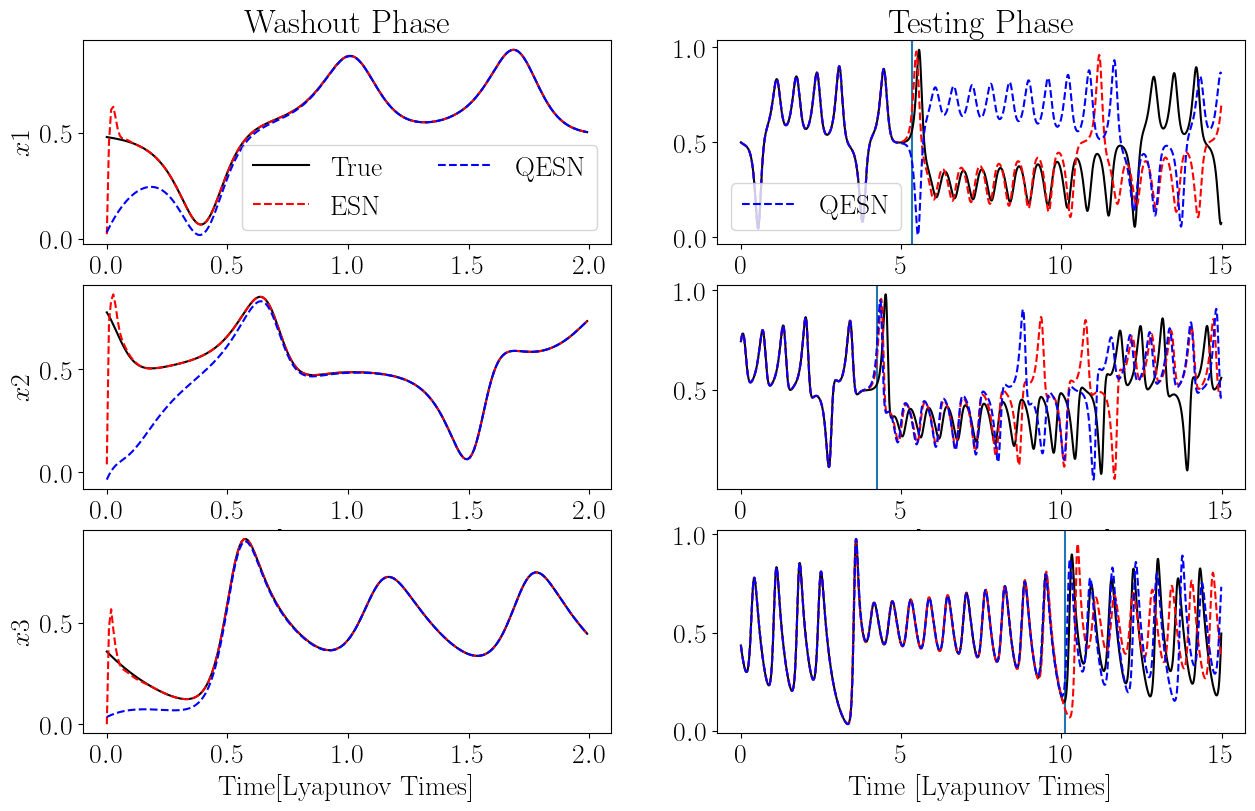

(98000, 3) (1, 98000, 3) 1
Realization    : 2
Hyperparameters: 1.0 0.5265211622664385 1.0 [1.e-09]
Quantum Hyperparameters: 1.0 0.05 1 [1.e-12] Seed: 2
PH quantiles [Lyapunov Times]: [8.22522523 4.40540541 3.91891892]

PH quantiles [Lyapunov Times]: [4.69369369 4.25225225 3.83783784]



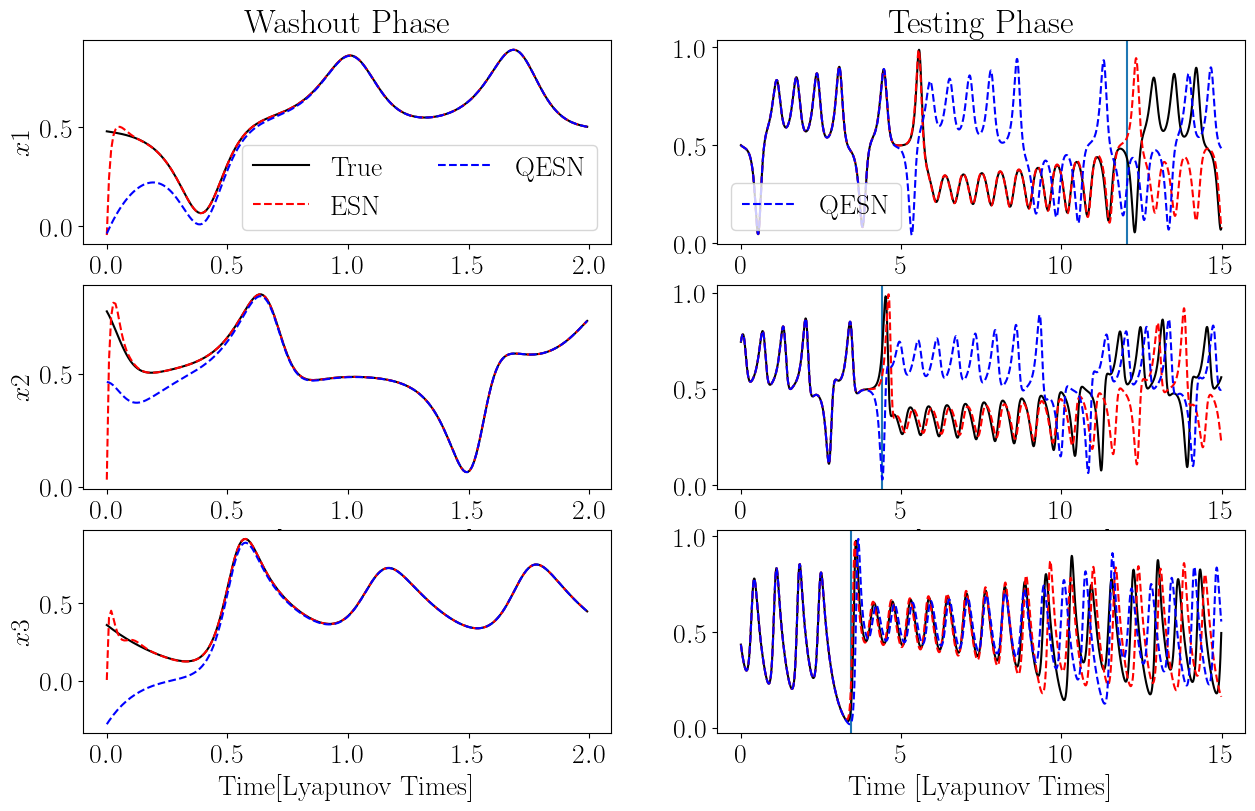

(98000, 3) (1, 98000, 3) 1
Realization    : 3
Hyperparameters: 1.0 0.7485520767773461 1.0 [1.e-09]
Quantum Hyperparameters: 1.0 0.05 1 [1.e-12] Seed: 3
PH quantiles [Lyapunov Times]: [4.72072072 4.24324324 3.87387387]

PH quantiles [Lyapunov Times]: [7.28828829 5.16216216 4.77477477]



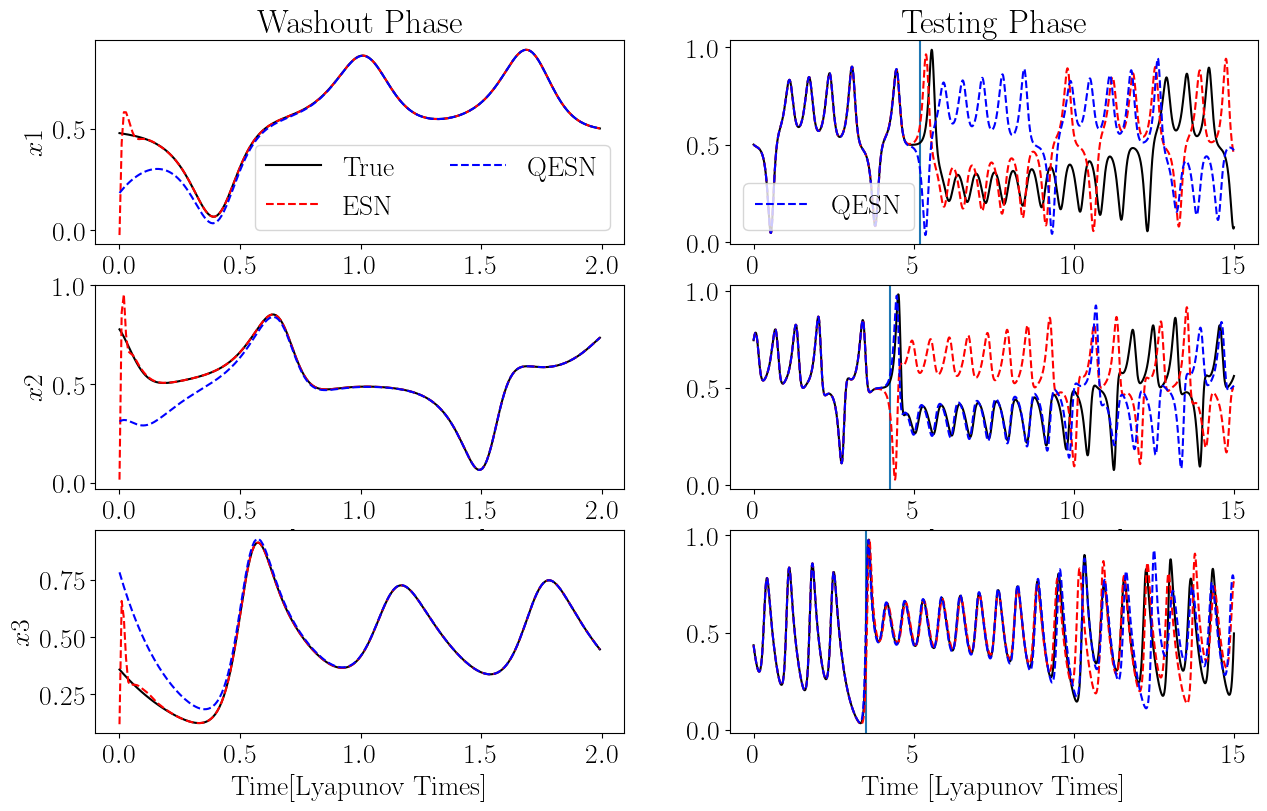

(98000, 3) (1, 98000, 3) 1
Realization    : 4
Hyperparameters: 1.0 0.8661289651095819 1.0 [1.e-09]
Quantum Hyperparameters: 1.0 0.05 1 [1.e-12] Seed: 4
PH quantiles [Lyapunov Times]: [4.73423423 4.27927928 3.83333333]

PH quantiles [Lyapunov Times]: [4.83783784 4.33333333 3.82432432]



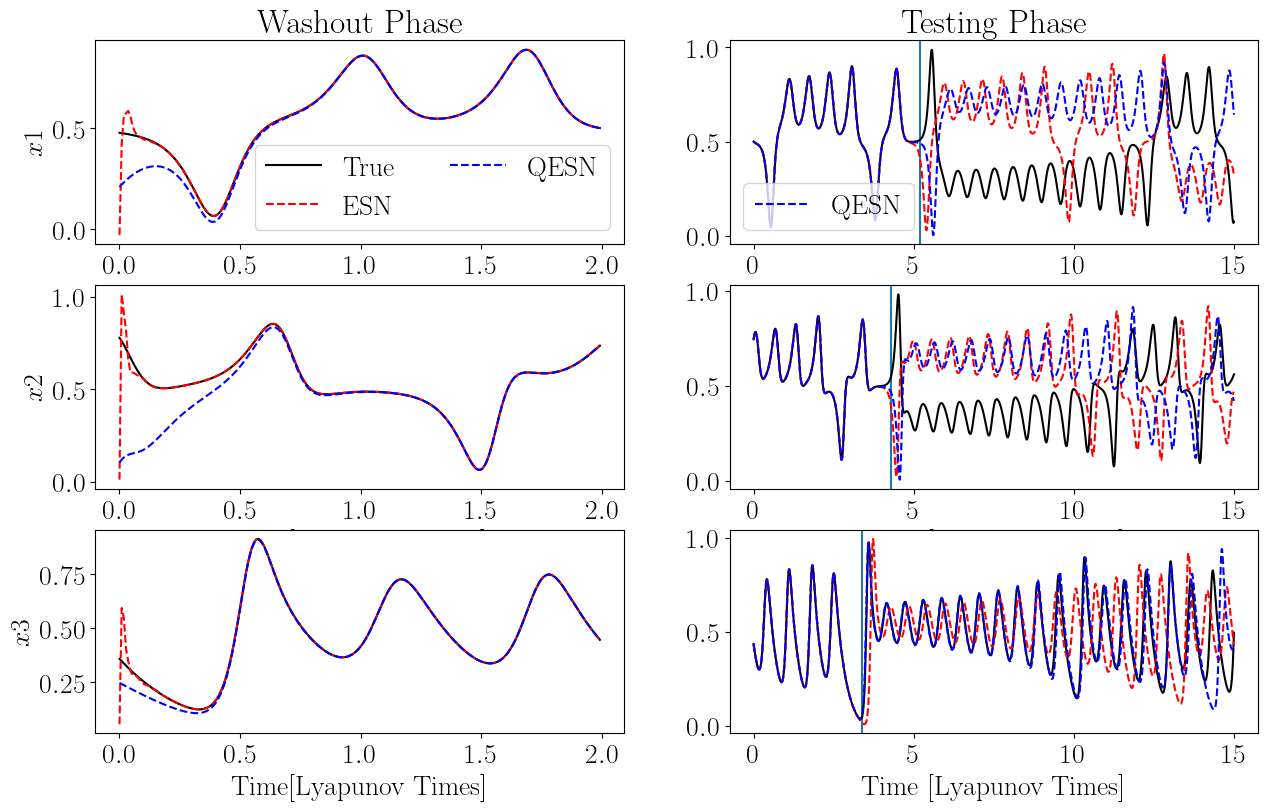

(98000, 3) (1, 98000, 3) 1
Realization    : 5
Hyperparameters: 1.0 0.7583625262036464 0.9313781852924004 [1.e-09]
Quantum Hyperparameters: 1.0 0.05 1 [1.e-12] Seed: 5
PH quantiles [Lyapunov Times]: [7.58108108 5.17117117 4.77027027]

PH quantiles [Lyapunov Times]: [7.76576577 5.15315315 4.31531532]



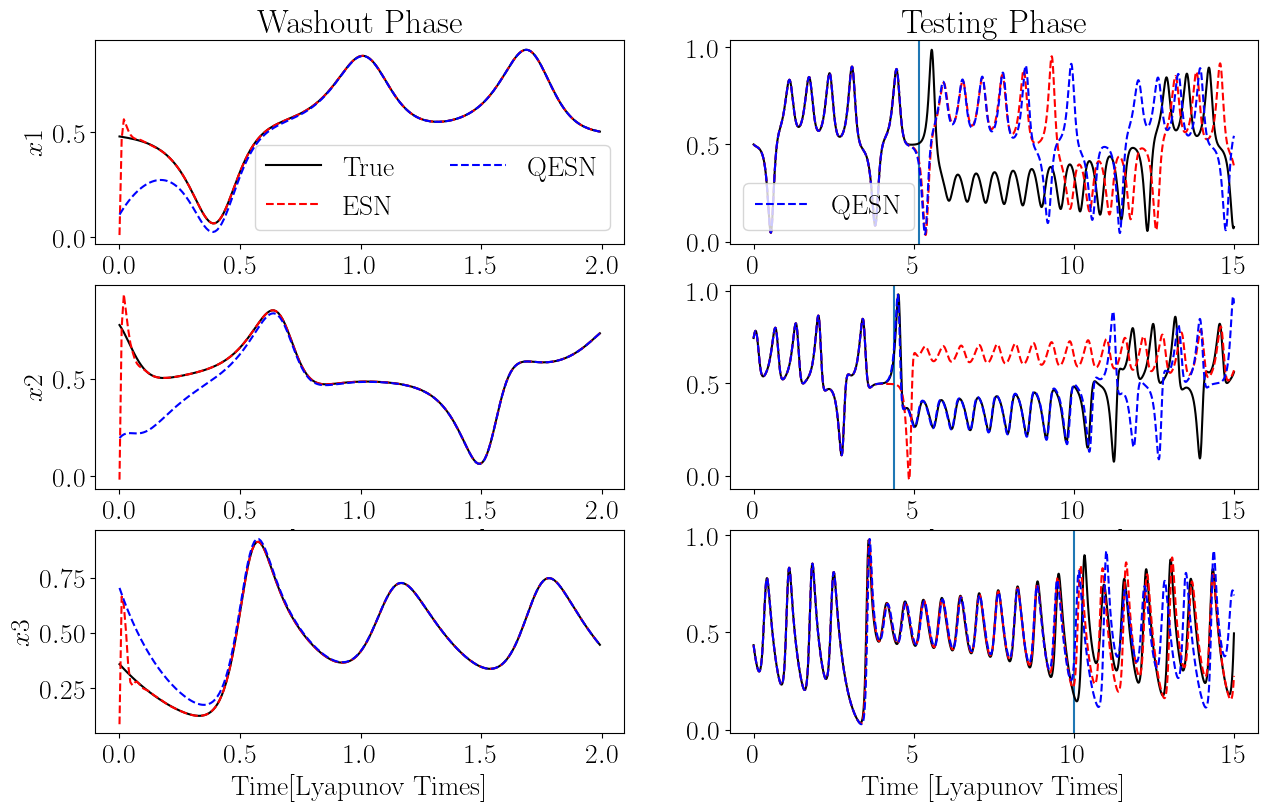

In [12]:
## MODIFY Post processing functionss
quantum_plots = True
N_test   = dim   #number of intervals in the test set
N_tstart = N_washout          # where the first test interval starts
N_intt   = 15*N_lyap          # length of each test set interval
N_fwd    = 1*N_lyap

len_open = N_washout          # Should be < N_washout because of implementation
len_closed = 10*N_lyap

factor = 100*N_lyap           # statistical predictions

Y_tp      =  []
Yh_tp     =  []
Yh_t_qp   =  []
PH_plot_p  =  []
PH_plot_pq =  []
PH_series  = []
PH_series_q  = []

time_series = np.array([0]) # relevant for MFE

            
for j in range(len(time_series)):
    num_series = time_series[j]
    print('For time series',num_series)

    for i in range(qu_ensemble):
        seed  = i+1
        Win   =  esn.gen_input_matrix(seed)
        W     =  esn.gen_reservoir_matrix(seed)

        if quantum_plots:
            U_wash, Uh_wash , Y_t , Yh_t , PH_plot , Uh_wash_q, Yh_t_q , PH_plot_q = lorenz63_timeseries_plot(N_test,N_tstart,N_intt,N_fwd,i,UU,U,U_test,N_washout,N_lyap,ensemble,N_t,minimum,esn,Win,W,QESN,Woutt,Woutt_qq,alpha_qq,plot=True,quantum=True)
            
            Y_tp       +=  [Y_t]
            Yh_tp      +=  [Yh_t]
            Yh_t_qp    +=  [Yh_t_q]
            PH_plot_p  += [PH_plot[i]]
            PH_plot_pq += [PH_plot_q[i]]
            
        else:
            U_wash, Uh_wash , Y_t , Yh_t , PH_plot , Uh_wash_q, Yh_t_q , PH_plot_q = lorenz63_timeseries_plot(N_test,N_tstart,N_intt,N_fwd,i,UU,U,U_test,N_washout,N_lyap,ensemble,N_t,minimum,esn,Win,W,QESN,Woutt,Woutt_qq,alpha_qq,plot=True,quantum=False)
            Y_tp      +=  [Y_t]
            Yh_tp     +=  [Yh_t]
            PH_plot_p += [PH_plot[i]]
            
    PH_series   += [PH_plot_p]
    PH_series_q += [PH_plot_pq]


# Prediction of Lyapunov Spectrum - CRC

In [14]:
step_le = 20001
# Adding noise helped classical lyapunov calculation

ens = 1 # Which ensemble to use for generating closed loop data and lyapunov exponents
for ens in range(5):
    num_series = time_series[0]

    esn.rho      = 10**minimum[ens,0]
    esn.epsilon  = minimum[ens,1]
    esn.sigma_in = minimum[ens,2]
    Win    =  esn.gen_input_matrix(ens+1)
    W      =  esn.gen_reservoir_matrix(ens+1)
    U_wash = U_test[num_series,N_tstart - N_washout +i*N_fwd : N_tstart + i*N_fwd].copy()

    Xa_wash   = esn.open_loop(U_wash, np.zeros(esn.N_units),Win,W) # here concatenation and bias out addition
    Uh_wash   = np.dot(Xa_wash, Woutt[ens])


    # Closed loop and Lyapunov Exponents

    # Yh, xa, LEs = esn.closed_loop_jacobian(system,step_le, dt,Xa_wash[-1], Win,W, Woutt[ens], norm, norm_time=1) # Implementation without leak rate

    Yh, xa, LEs = esn.closed_loop_jacobian_leakrate(system,step_le, dt,Xa_wash[-1], Win,W, Woutt[ens], norm, norm_time=1) # Implementation with leak rate



Inside closed loop i= 20000
ESN Lyapunov exponents:  [ 9.31781669e-01 -1.31508298e-02 -1.34698763e+01]
Inside closed loop i= 20000
ESN Lyapunov exponents:  [ 8.76691219e-01  9.07606374e-03 -9.29975004e+00]
Inside closed loop i= 20000
ESN Lyapunov exponents:  [ 8.98776270e-01  8.97835084e-04 -1.23380715e+01]
Inside closed loop i= 20000
ESN Lyapunov exponents:  [  0.91408149  -0.0117167  -10.37689833]
Inside closed loop i= 20000
ESN Lyapunov exponents:  [ 8.83897570e-01 -9.60295633e-04 -1.21618168e+01]


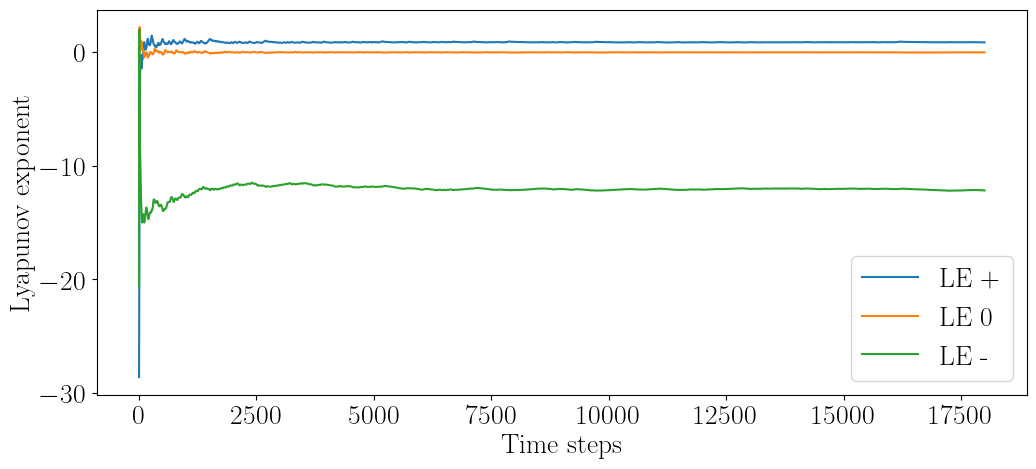

In [15]:
plt.rcParams["figure.figsize"] = (12,5)
plt.rcParams["font.size"] = 20

if save_fold == 'VPT_L63':
    plt.plot(LEs[:,0], label='LE +')
    plt.plot(LEs[:,1], label='LE 0')
    plt.plot(LEs[:,2], label='LE -')
    
plt.xlabel("Time steps")
plt.ylabel("Lyapunov exponent")
plt.legend()
plt.show()

# Prediction of Lyapunov Spectrum - QRC

In [16]:
step_le = 20001
ens = -1 # Which ensemble to use for generating closed loop data and lyapunov exponents

num_series = time_series[0]

U_wash = U_test[num_series,N_tstart - N_washout +i*N_fwd : N_tstart + i*N_fwd].copy()

alpha = alpha_qq[ens]

Xa_wash   = QESN.quantum_openloop(U_wash, np.zeros(QESN.N_units),alpha) # here concatenation and bias out addition
Uh_wash   = np.dot(Xa_wash, Woutt_qc[ens])


# Closed loop and Lyapunov Exponents

Yh_q, xa_q, LEs_q = QESN.quantum_closed_loop_jacobian_leakrate(system,step_le, dt,Xa_wash[-1], alpha, Woutt_qc[ens], norm, norm_time=1,layered=True) # Implementation with leak rate
# If layered = False, remove double unitary from quantum step function in config 4...


Inside closed loop i= 20000
ESN Lyapunov exponents:  [ 9.00303968e-01  3.24238463e-03 -5.12932655e+00]


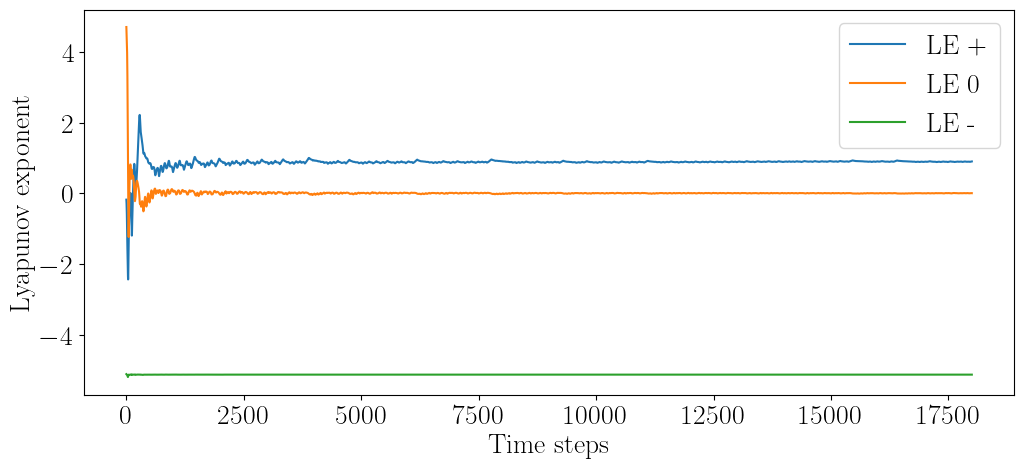

In [17]:
plt.rcParams["figure.figsize"] = (12,5)
plt.rcParams["font.size"] = 20

if save_fold == 'VPT_L63':
    plt.plot(LEs_q[:,0], label='LE +')
    plt.plot(LEs_q[:,1], label='LE 0')
    plt.plot(LEs_q[:,2], label='LE -')
    
plt.xlabel("Time steps")
plt.ylabel("Lyapunov exponent")
plt.legend()
plt.show()